# Ideas and Testing them for ODEs and BVPs

## Adaptive BVP

The problem is the following:

$$
x \in \left[0, 1\right], \quad \frac{d}{dx} \left(p(x) \frac{dy}{dx}\right) + q(x) y(x) = f(x)
\quad a_0 y(0) + b_0 y'(0) = c_0, \quad a_1 y(1) + b_1 y'(1) = c_1
$$

Which is the standard Sturm-Liouville problem in one dimension.  The goal is to solve for $y(x)$.  Currently, we can discretize the domain by using $N$ interior points.  Including the boundaries is $N + 2$ points.  The main equation to solve can be converted into a linear system of the form:

$$A y = f$$

Where $A$ is an $N + 2 \times N + 2$ matrix, and $y$ and $f$ are both $N + 2$ vectors.  Solving for the vector $y$ 
will give $y_i = y(x_i)$, where $i = 0, ..., N + 1$ is the approximation to $y(x)$.  This can be done and is demonstrated below.  For sake of argument, we will take $p(x) \equiv 1$, $q(x) \equiv 0$, and $f(x) = k(kx - 2) e^{-kx}$.  Finally we will set the boundary conditions ot $y(0) = 0$ and $y'(1) = 0$.Under these assumptions the problem becomes:

$$
x \in \left[0, 1\right], \quad \frac{d^2 y}{dx^2} = k(kx - 2)e^{-kx}, \quad y(0) = y'(1) = 0, \quad k > 0
$$

The exact solution to this problem can be computed and is

$$
y(x) = xe^{-kx} - x(1 - k) e^{-k}
$$

In [91]:
# imports and such
import numpy as np
import matplotlib.pyplot as plt

# my libraries
from ode import diffmat
import linalg

In [92]:
# set value of k and build exact solution
k = 10
y_exact = lambda x: x * np.exp(-k * x) - x * (1 - k) * np.exp(-k)

In [114]:
# build the problem
bcs = np.array([[1, 0, 0], [0, 1, 0]])

f = lambda x: k * (k * x - 2) * np.exp(-k * x)

N = 50
xspan = [0, 1]


x = np.linspace(xspan[0], xspan[1], N+2)
order = 4
Dxx = diffmat(x, 2, order)
A = Dxx[:, :]

# augment with boundary conditions
Dx = diffmat(x, 1, order)
A[0, :] = bcs[0,1] * Dx[0,:]
A[0, 0] += bcs[0,0]
A[-1, :] = bcs[1,1] * Dx[-1,:]
A[-1, -1] += bcs[1,0]

f_vec = f(x)
f_vec[0] = bcs[0, 2]
f_vec[-1] = bcs[1, 2]

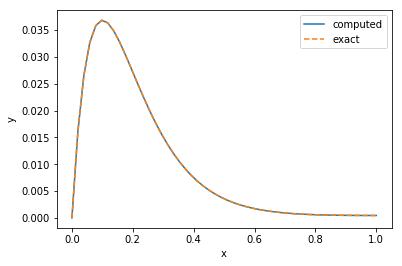

In [115]:
# solution
y = linalg.linalg_solve(A, f_vec)

# plotting
plt.figure()
plt.plot(x, y, label="computed")
plt.plot(x, y_exact(x), '--', label="exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

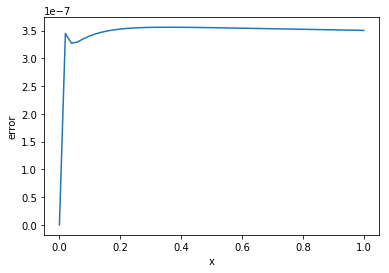

3.5599109422974895e-07


In [116]:
# errors
err = np.abs(y - y_exact(x))

plt.figure()
plt.plot(x, err)
plt.xlabel('x')
plt.ylabel('error')
plt.show()

print(np.max(err))

Can we fix these errors?  For this approach, we will choose the $x$ locations adaptively.  To do so we need the local truncation error.  

The problem was solved using a second order accurate differentiation matrix.  For interior points, the local truncation error is given by

$$
\tau = \Delta x^2 \frac{d^4 y}{dx^4} + O(\Delta x^3)
$$

Hence second order accuracy.  Returning to the differential equation, the value $\frac{d^4 y}{dx^4}$ can be computed by

$$
\frac{d^4 y}{dx^4} = \frac{d^2}{dx^2} \frac{d^2 y}{dx^2} = \frac{d^2}{dx^2} f(x)
$$

So by computing the second derivative of $f(x)$, we find the error.  Setting a tolerance value $\epsilon$, then the spacing of the discretization points can be computed by

$$
\Delta x \leq \sqrt{\frac{\epsilon}{d^2 f / dx^2}}
$$

This does not need to be done everywhere however, only where the quantity on the right is smaller than the current spacing $\Delta x$.

/home/jerome/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


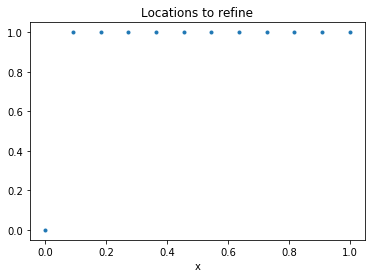

In [96]:
dx = x[1] - x[0]
tol = 1e-4

refine_locs = np.sqrt(tol / np.abs(Dxx @ f_vec)) < dx

plt.figure()
plt.plot(x, refine_locs, '.')
plt.xlabel('x')
plt.title('Locations to refine')
plt.show()

At each of the locations, we can split the subinterval into two smaller subintervals.  This can be compared repeatedly to drop the error to below the tolerance threshold

In [97]:
# interval refining
x_list = list(x)
indices = np.arange(0, len(x_list))
count = 0
for ind in indices[refine_locs]:
    # skip first and last entries, does not apply
    if ind == 0 or ind == len(x_list) - 1:
        continue
    else:
        # insert element halfway between left and self
        left_pos = 0.5 * (x[ind] + x[ind-1])
        x_list.insert(ind + count, left_pos)
        count += 1

x_new = np.array(x_list)

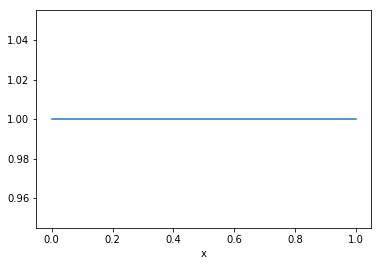

In [98]:
# compute new error
Dxx_new = diffmat(x_new, 2, order)

f_vec_new = f(x_new)

err_new = Dxx_new @ f_vec_new

dx_new = dx / 2
refine_locs_new = np.sqrt(tol / np.abs(err_new)) < dx_new

plt.plot(x_new, refine_locs_new)
plt.xlabel('x')
plt.show()

In [99]:
# now we repeat using a function
def refine_x(x_curr, refine_locs):
    """
    Refine the x positions at the designated locations
    
    Input:
        x_curr - numpy array of current x positions
        refine_locs - list of locations to refine
    Output:
        x_new - refined x positions
    """
    
    x_list = list(x_curr)
    indices = np.arange(0, len(x_list))
    count = 0
    
    for ind in indices[refine_locs]:
        if ind == 0 or ind == len(x_list) - 1:
            continue
        else:
            left_pos = 0.5 * (x_curr[ind] + x_curr[ind - 1])
            x_list.insert(ind + count, left_pos)
            count += 1
    return np.array(x_list)

x_new2 = refine_x(x_new, refine_locs_new)

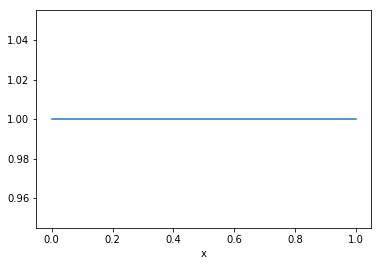

In [100]:
# update errors
dx_new /= 2

Dxx_new = diffmat(x_new2, 2, order)

f_vec_new = f(x_new2)

err_new = Dxx_new @ f_vec_new

refine_locs_new = np.sqrt(tol / np.abs(err_new)) < dx_new

plt.plot(x_new2, refine_locs_new)
plt.xlabel('x')
plt.show()

In [101]:
# looping to refine errors
more_refine = True
x_new3 = x_new2[:]
while more_refine:
    x_new3 = refine_x(x_new3, refine_locs_new)
    dx_new /= 2
    Dxx_new = diffmat(x_new3, 2, order)
    f_vec_new = f(x_new3)
    err_new = Dxx_new @ f_vec_new
    refine_locs_new = np.sqrt(tol / np.abs(err_new)) < dx_new
    more_refine = np.sum(refine_locs_new) > 1
print(len(x_new3))

1376


After two layers of refinement, the local truncation error everywhere is below the tolerance threshold.  Now we can compute the updated solution

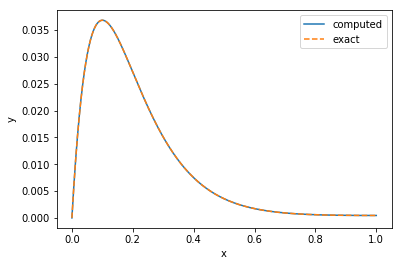

In [102]:
# build the updated problem

# updated differentiation matrix
Dxx = diffmat(x_new3, 2, order)
A = Dxx[:, :]

# augment with boundary conditions
Dx = diffmat(x_new3, 1, order)
A[0, :] = bcs[0,1] * Dx[0,:]
A[0, 0] += bcs[0,0]
A[-1, :] = bcs[1,1] * Dx[-1,:]
A[-1, -1] += bcs[1,0]
f_vec_new[0] = bcs[0, 2]
f_vec_new[-1] = bcs[1, 2]

# construct and plot solution
# solution
y = linalg.linalg_solve(A, f_vec_new)

# plotting
plt.figure()
plt.plot(x_new3, y, label="computed")
plt.plot(x_new3, y_exact(x_new3), '--', label="exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


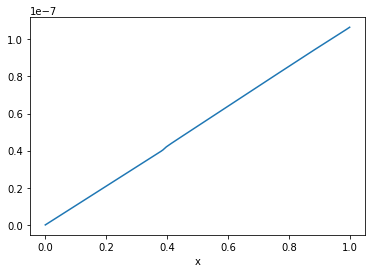

1.0647757676555741e-07


In [103]:
# new true errors
err_new = np.abs(y - y_exact(x_new3))
plt.plot(x_new3, err_new)
plt.xlabel('x')
plt.show()

print(np.max(err_new))

1376


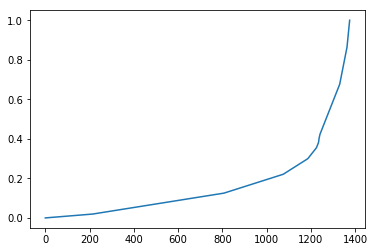

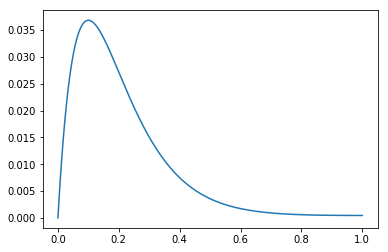

In [108]:
print(len(x_new3))

plt.plot(x_new3)

plt.figure()
plt.plot(x_new3, y_exact(x_new3))


Let's put everything together into a set of callable functions for ease of use.  We already have the spacial refinement function.  Next we need a rule to determine where to refine.  This will be based off 
an error computation and a tolerance value.

In [147]:
def grid_refine(xspan, error_fun, tol=1e-6, n_init=10, max_iter=10):
    """
    Refine a grid
    
    Input:
        xspan - [a, b]
        error_fun - callable, parameters x, dx, gives the error of the discretization
    Optional:
        tol - tolerance value for error, defaults to 10^-6
        n_init - initial number of x points, defaults to 10
        max_iter - maximum number of allowed iterations, defaults to 10
    Output:
        x - refined x positions
    """
    
    # loop preliminaries
    it = 0
    x = np.linspace(xspan[0], xspan[1], n_init)
    dx = x[1] - x[0]
    
    # is it good enough?
    err = error_fun(x, dx)
    refine_locs = err > tol
    
    refine = np.sum(refine_locs) > 0
    
    # refinement loop
    while refine:
        # refine positions
        x = refine_x(x, refine_locs)
        
        dx /= 2
        # update error and where needs to be refined
        err = error_fun(x, dx)
        refine_locs = err > tol
        refine = np.sum(refine_locs) > 0
        
        # do not exceed max_iter iterations
        it += 1
        if it > max_iter:
            print("Warning, maximum number of refinements reached")
            break
    print("total iterations: ", it)
    return x
        

Let us test this on the following problem:

$$
\frac{d^2 y}{dx^2} = f(x) = e^{-100x^2}, \quad x \in \left[-1, 1\right], \quad 
y(\pm 1) = 0
$$

Below is a plot of $f(x)$

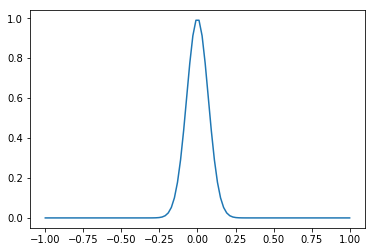

In [124]:
x = np.linspace(-1, 1, 100)
y = np.exp(-100 * np.power(x, 2))

plt.plot(x, y)

It can be seen that $f(x) \approx 0$ for $|x| > 1/4$.  Therefore we expect most of the grid refinement to be near the origin.  We will use a second order differentiation matrix $D_{xx}$ for the second derivative w.r.t. $x$.  From computation before, it is known the error is then 

$$
\tau(x, \Delta x) = \frac{\Delta x^2}{6} \left|\left|\frac{d^2 f}{dx^2}\right|\right| \approx 
\frac{\Delta x^2}{6} \left|\left| D_{xx} f \right|\right|
$$

total iterations:  12
2234


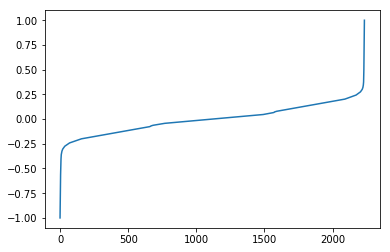

In [151]:
tol = 1e-6
xspan = [-1, 1]
n_init = 5

def error_fun(x, dx, f):
    Dxx = diffmat(x, 2, 2)
    f_vec = f(x)
    
    err = np.power(dx, 2) / 6 *  Dxx @ f_vec
    return np.abs(err)

f_exp = lambda x: np.exp(-100 * np.power(x, 2))
error = lambda x, dx: error_fun(x, dx, f_exp)
    
x_opt = grid_refine(xspan, error, tol=tol, n_init=n_init, max_iter=100)

print(len(x_opt))
plt.plot(x_opt)

The results are promissing.  The refinement converged after 12 iterations, and the problem only requires 2234 $x$ points.  The results are what was expected, almost no refinement on the edges, with significant refinement near the origin.  Now let's solve the problem.

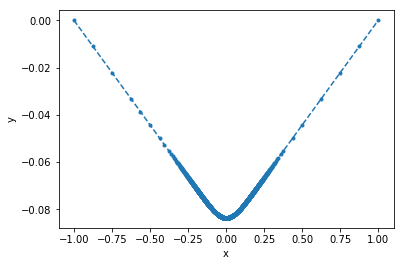

In [155]:
f_vec = f_exp(x_opt)
Dxx = diffmat(x_opt, 2, 2)

A = Dxx[:, :]
A[0, :] = 0
A[0, 0] = 1
A[-1, :] = 0
A[-1, -1] = 1

f_vec[0] = 0
f_vec[-1] = 0

y = linalg.linalg_solve(Dxx, f_vec)

plt.plot(x_opt, y, '.--', label="opt")
plt.xlabel('x')
plt.ylabel('y')
plt.show()

